# Planning Permits Analysis

This analysis uses data from https://discover.data.vic.gov.au/dataset?q=planning%20permits.


'The Victorian Building Authority (VBA) collects information from building surveyors on the number, value and type of building permits issued each month as part of its functions under the Building Act 1993'
 
Firstly there is also a building permit activity monthly summary dataset which has been updated to April 2021 (https://discover.data.vic.gov.au/dataset/building-permit-activity-monthly-summaries). This is an aggregated dataset which includes data visualisations which track building use, costs, 


The summary dataset aggregates data from separate annual datesets which run from to 2020 (https://discover.data.vic.gov.au/dataset/building-permit-activity-data-2020). ** up to 2021 on building vic autority (VBA) site ** Within these datasets, each record or row represents a single permit.

These annual datasets include over 40 pieces of information per record, such as details of what is to be built (or demolished),the intended use of the building, the ownership sector, and the building costs. 

In addition, the location of the building can be viewed down to the street name level, with postal codes, suburbs and regions also included.

A comprehensive data dictionary for the building permit datsets can be found on the VBA site here (https://www.vba.vic.gov.au/about/data), as well as a detailed data quality statement PDF which includes clear summaries about what the data represents.

In [2]:
import numpy as np
import pandas as pd
import requests
import json
import geopandas as gpd
import os
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

visuals = '../docs/visuals/building_permits/'


In [3]:
# VBA DataVic data, hosted on VBA website
dataset_urls = {
    '2021':'https://www.vba.vic.gov.au/__data/assets/file/0007/146572/VBA-DataVic-Building-Permits-2021-Nov.xlsb',
    '2020':'https://www.vba.vic.gov.au/__data/assets/file/0012/110028/VBA-DataVic-Building-Permits-2020.xlsb',
    '2019':'https://www.vba.vic.gov.au/__data/assets/file/0015/103515/VBA-DataVic-Building-Permits-2019.xlsb'
}

dfs = {}

for dataset in dataset_urls:
    if dataset_urls[dataset].endswith('xlsb'):
        # to read xlsb, you need to install pyxlsb using pip at command prompt (pip install pyxlsb)
        dfs[dataset] = pd.read_excel(dataset_urls[dataset],sheet_name=1,engine='pyxlsb') 
    else:
        dfs[dataset] = pd.read_excel(dataset_urls[dataset],sheet_name=1) 
        

In [4]:
# Do the datasets contain the same number of variables?
for year in dfs:
    print(f'{year}: {len(dfs[year].columns)}')
    
len(dfs['2019'].columns)== len(dfs['2020'].columns) == len(dfs['2021'].columns)

2021: 37
2020: 37
2019: 41


False

In [5]:
# The 2019 dataset has more variables than the subsequent years; let's come back to 2019 

# First, let's check that the 37 variables in the 2020 and 2021 datasets are the same

for i,assertion in enumerate(dfs['2020'].columns == dfs['2021'].columns):
    if assertion == False:
        print(f"Year  Mis-matched column")
        for year in ['2020','2021']:
            print(f'{year}: {dfs[year].columns[i]}')


Year  Mis-matched column
2020: BASIS_ BCA
2021: BASIS_BCA


In [6]:
# The column 'BASIS_BCA' is mis-spelt in the 2020 dataset; let's correct that
dfs['2020'].rename(columns={'BASIS_ BCA':'BASIS_BCA'},inplace=True)

In [7]:
# let's confirm that's fixed now:
for i,assertion in enumerate(dfs['2020'].columns == dfs['2021'].columns):
    if assertion == False:
        print(f"Year  Mis-matched column")
        for year in ['2020','2021']:
            print(f'{year}: {dfs[year].columns[i]}')

# yes, all good!

In [8]:
# Let's look at the 2019 and 2020 variables
print(dfs['2019'].columns)
print(dfs['2020'].columns)


Index(['permit_stage_number', 'permit_date', 'BASIS_Month_Y', 'BASIS_Month_M',
       'Reported_Levy_amount', 'Calculated_Levy_amount',
       'Reported_Cost_of_works', 'Site_street', 'Site_suburb', 'site_pcode',
       'Municipal Name', 'Municipal Full Name', 'Region', 'Sub_Region',
       'Sub_Region1', 'Allotment_Area', 'Builder_suburb', 'Builder_state',
       'Builder_pcode', 'Material_Code_Floor', 'Material_Code_Frame',
       'Material_Code_Roof', 'Material_Code_Walls', 'dwellings_before_work',
       'dwellings_after_work', 'Number_of_storeys', 'number_demolished',
       'Floor_area', 'Multiple_Dwellings', 'cost_of_works_domestic',
       'Permit_app_date', 'BACV_applicable_flag', 'Calculated_levy_BACV',
       'solar_hot_water', 'rainwater_tank', 'est_cost_project',
       'BASIS_Building_Use', 'BASIS_NOW', 'BASIS_BCA', 'BASIS_OwnershipSector',
       'BASIS_OwnerBuilder'],
      dtype='object')
Index(['permit_stage_number', 'permit_date', 'BASIS_Month_Y', 'BASIS_Month_M',
  

The 2019 variables are in a different order, and spelt differently.

To determine how to proceed, lets compare

- The VBA data dictonary (last modified 2015, at time of writing)
- The 2019 dataset columns
- The consolidated 2020/21 columns (following space correction of BASIS_BCA variable name, above)
- A combined proposed plain text variable name without special characters 

| ID | Data dictionary        |          2019          |               2020/21               | Proposed variable name        |
|----|------------------------|:----------------------:|:-----------------------------------:|-------------------------------|
| 1  | permit_stage_number    | permit_stage_number    | permit_stage_number                 | Permit Stage Number           |
| 2  | permit_date            | permit_date            | permit_date                         | Permit Date                   |
| 3  | BASIS_Month_Y          | BASIS_Month_Y          | BASIS_Month_Y                       | Year                          |
| 4  | BASIS_Month_M          | BASIS_Month_M          | BASIS_Month_M                       | Month                         |
| 5  | Reported_Levy_amount   | Reported_Levy_amount   |                                     | Reported Levy Amount          |
| 6  | Calculated_Levy_amount | Calculated_Levy_amount |                                     | Calculated Levy Amount        |
| 7  |                        |                        | Original_Levy_Paid__c               | Original Levy Paid            |
| 8  | Reported_Cost_of_works | Reported_Cost_of_works | Reported_Cost_of_works              | Reported Cost Of Works        |
| 9  | Site_street            | Site_street            | site_street_name__c                 | Site Street                   |
| 10 | Site_suburb            | Site_suburb            | site_town_suburb__c                 | Site Suburb                   |
| 11 | site_pcode             | site_pcode             | site_postcode__c                    | Site Postcode                 |
| 12 | Municipal name         | Municipal Name         | Site_Municipality                   | Municipal Name                |
| 13 | Municipal full name    | Municipal Full Name    | Municipal Full Name                 | Municipal Full Name           |
| 14 | Region                 | Region                 | Region                              | Region                        |
| 15 | Sub_Region             | Sub_Region             | Sub_Region                          | Sub Region                    |
| 16 | Sub_Region1            | Sub_Region1            | Sub_Region1                         | Sub Region1                   |
| 17 | Allotment_Area         | Allotment_Area         | Allotment_Area__c                   | Allotment Area                |
| 18 | Builder_suburb         | Builder_suburb         | Builder_Town_Suburb__c              | Builder Suburb                |
| 19 | Builder_state          | Builder_state          | Builder_State__c                    | Builder State                 |
| 20 | Builder_pcode          | Builder_pcode          | Builder_Postcode__c                 | Builder Postcode              |
| 21 | Material_Code_Floor    | Material_Code_Floor    | Floor_Material__c                   | Material Code Floor           |
| 22 | Material_Code_Frame    | Material_Code_Frame    | Frame_Material__c                   | Material Code Frame           |
| 23 | Material_Code_Roof     | Material_Code_Roof     | Roof_Cladding_Material__c           | Material Code Roof            |
| 24 | Material_Code_Walls    | Material_Code_Walls    | External_Wall_Material__c           | Material Code Walls           |
| 25 | dwellings_before_work  | dwellings_before_work  | Number_of_Existing_Dwellings__c     | Existing Dwellings            |
| 26 | dwellings_after_work   | dwellings_after_work   | Number_of_New_Dwellings__c          | New Dwellings                 |
| 27 | Number_of_storeys      | Number_of_storeys      | Number_of_Storeys__c                | Storeys                       |
| 28 | number_demolished      | number_demolished      | Number_of_Dwellings_Demolished__c   | Dwellings Demolished          |
| 29 | Floor_area             | Floor_area             | Total_Floor_Area__c                 | Floor Area                    |
| 30 | Multiple_Dwellings     | Multiple_Dwellings     |                                     | Multiple Dwellings            |
| 31 | cost_of_works_domestic | cost_of_works_domestic |                                     | Cost Of Works Domestic        |
| 32 | Permit_app_date        | Permit_app_date        | Building_Permit_Application_Date__c | Permit Application Date       |
| 33 | BACV_applicable_flag   | BACV_applicable_flag   |                                     | BACV Applicable Flag          |
| 34 | Calculated_levy_BACV   | Calculated_levy_BACV   |                                     | Calculated Levy BACV          |
| 35 |                        |                        | DBDRV Levy                          | DBDRV Levy                    |
| 36 | solar_hot_water        | solar_hot_water        | Solar_Hot_Water_Indicator__c        | Solar Hot Water               |
| 37 | rainwater_tank         | rainwater_tank         | Rainwater_Tank_Indicator__c         | Rainwater Tank                |
| 38 | est_cost_project       | est_cost_project       | Total_Estimated_Cost_of_Works__c    | Total Estimated Cost of Works |
| 39 | BASIS_Zone             | BASIS_Building_Use     | BASIS_Building_Use                  | BASIS Building Use            |
| 40 | BASIS_NOW              | BASIS_NOW              | BASIS_NOW                           | BASIS NOW                     |
| 41 | BASIS_BCA              | BASIS_BCA              | BASIS_BCA                           | BASIS BCA                     |
| 42 | BASIS_OwnershipSector  | BASIS_OwnershipSector  | BASIS_Ownership_Sector              | BASIS Ownership Sector        |
| 43 | BASIS_OwnerBuilder     | BASIS_OwnerBuilder     | BASIS_Owner_Builder                 | BASIS Owner Builder           |

Through this comparison it is apparent that,

- The 2019 dataset is mostly in accord with the data dictionary
- The data dictionary variable 'BASIS_ZONE' appears to have been framed as 'BASIS_NOW' in the 2019, 2020 and 2021 datasets
- Reported and calculated levy amounts are not recorded in 2020/21; there was an original levy paid variable instead
- Multiple dwellings and domestic cost of works was not recorded in 2020/21
- The BACV applicable flag and calculated levy were not recorded in 2020/21; there is however a 'DBDRV Levy'

Now we will ensure that each year shares the same variables and names, with missing values where these variables do not directly correspond, as per the proposed variable names in the table above.

In [9]:
# create columns which did not exist with null values
dfs['2019']['Original Levy Paid'] = np.nan
dfs['2019']['DBDRV Levy'] = np.nan
for year in ['2020','2021']:
    dfs[year]['Reported Levy Amount'] = np.nan
    dfs[year]['Calculated Levy Amount'] = np.nan
    dfs[year]['Multiple Dwellings'] = np.nan
    dfs[year]['Cost Of Works Domestic'] = np.nan
    dfs[year]['BACV Applicable Flag'] = np.nan
    dfs[year]['Calculated Levy BACV'] = np.nan

# rename columns
rename_2019_to_proposed = {'permit_stage_number':'Permit Stage Number','permit_date':'Permit Date','BASIS_Month_Y':'Year','BASIS_Month_M':'Month','Reported_Levy_amount':'Reported Levy Amount','Calculated_Levy_amount':'Calculated Levy Amount','Reported_Cost_of_works':'Reported Cost Of Works','Site_street':'Site Street','Site_suburb':'Site Suburb','site_pcode':'Site Postcode','Municipal Name':'Municipal Name','Municipal Full Name':'Municipal Full Name','Region':'Region','Sub_Region':'Sub Region','Sub_Region1':'Sub Region1','Allotment_Area':'Allotment Area','Builder_suburb':'Builder Suburb','Builder_state':'Builder State','Builder_pcode':'Builder Postcode','Material_Code_Floor':'Material Code Floor','Material_Code_Frame':'Material Code Frame','Material_Code_Roof':'Material Code Roof','Material_Code_Walls':'Material Code Walls','dwellings_before_work':'Existing Dwellings','dwellings_after_work':'New Dwellings','Number_of_storeys':'Storeys','number_demolished':'Dwellings Demolished','Floor_area':'Floor Area','Multiple_Dwellings':'Multiple Dwellings','cost_of_works_domestic':'Cost Of Works Domestic','Permit_app_date':'Permit Application Date','BACV_applicable_flag':'BACV Applicable Flag','Calculated_levy_BACV':'Calculated Levy BACV','solar_hot_water':'Solar Hot Water','rainwater_tank':'Rainwater Tank','est_cost_project':'Total Estimated Cost of Works','BASIS_Building_Use':'BASIS Building Use','BASIS_NOW':'BASIS NOW','BASIS_BCA':'BASIS BCA','BASIS_OwnershipSector':'BASIS Ownership Sector','BASIS_OwnerBuilder':'BASIS Owner Builder'}
rename_202x_to_proposed = {'permit_stage_number':'Permit Stage Number','permit_date':'Permit Date','BASIS_Month_Y':'Year','BASIS_Month_M':'Month','Original_Levy_Paid__c':'Original Levy Paid','Reported_Cost_of_works':'Reported Cost Of Works','site_street_name__c':'Site Street','site_town_suburb__c':'Site Suburb','site_postcode__c':'Site Postcode','Site_Municipality':'Municipal Name','Municipal Full Name':'Municipal Full Name','Region':'Region','Sub_Region':'Sub Region','Sub_Region1':'Sub Region1','Allotment_Area__c':'Allotment Area','Builder_Town_Suburb__c':'Builder Suburb','Builder_State__c':'Builder State','Builder_Postcode__c':'Builder Postcode','Floor_Material__c':'Material Code Floor','Frame_Material__c':'Material Code Frame','Roof_Cladding_Material__c':'Material Code Roof','External_Wall_Material__c':'Material Code Walls','Number_of_Existing_Dwellings__c':'Existing Dwellings','Number_of_New_Dwellings__c':'New Dwellings','Number_of_Storeys__c':'Storeys','Number_of_Dwellings_Demolished__c':'Dwellings Demolished','Total_Floor_Area__c':'Floor Area','Building_Permit_Application_Date__c':'Permit Application Date','DBDRV Levy':'DBDRV Levy','Solar_Hot_Water_Indicator__c':'Solar Hot Water','Rainwater_Tank_Indicator__c':'Rainwater Tank','Total_Estimated_Cost_of_Works__c':'Total Estimated Cost of Works','BASIS_Building_Use':'BASIS Building Use','BASIS_NOW':'BASIS NOW','BASIS_BCA':'BASIS BCA','BASIS_Ownership_Sector':'BASIS Ownership Sector','BASIS_Owner_Builder':'BASIS Owner Builder'}

dfs['2019'].rename(columns = rename_2019_to_proposed,inplace=True)
dfs['2020'].rename(columns = rename_202x_to_proposed,inplace=True)
dfs['2021'].rename(columns = rename_202x_to_proposed,inplace=True)

# order columns
columns = ['Permit Stage Number','Permit Date','Year','Month','Reported Levy Amount','Calculated Levy Amount','Original Levy Paid','Reported Cost Of Works','Site Street','Site Suburb','Site Postcode','Municipal Name','Municipal Full Name','Region','Sub Region','Sub Region1','Allotment Area','Builder Suburb','Builder State','Builder Postcode','Material Code Floor','Material Code Frame','Material Code Roof','Material Code Walls','Existing Dwellings','New Dwellings','Storeys','Dwellings Demolished','Floor Area','Multiple Dwellings','Cost Of Works Domestic','Permit Application Date','BACV Applicable Flag','Calculated Levy BACV','DBDRV Levy','Solar Hot Water','Rainwater Tank','Total Estimated Cost of Works','BASIS Building Use','BASIS NOW','BASIS BCA','BASIS Ownership Sector','BASIS Owner Builder']
for year in ['2019','2020','2021']:
    dfs[year] = dfs[year][columns]
    


In [10]:
# Confirm that the year variable correctly indexes each year, and year is not missing
# This is important for when we join these seperate datasets to ensure they can be 
# correctly distinguished
years = ['2019','2020','2021']
for year in ['2019','2020','2021']:
    print(f'\n{year}')
    print(dfs[year]['Year'].describe())
    print(f'Missing year: {dfs[year]["Year"].isna().sum()}')



2019
count    101988.0
mean       2019.0
std           0.0
min        2019.0
25%        2019.0
50%        2019.0
75%        2019.0
max        2019.0
Name: Year, dtype: float64
Missing year: 0

2020
count    113430.0
mean       2020.0
std           0.0
min        2020.0
25%        2020.0
50%        2020.0
75%        2020.0
max        2020.0
Name: Year, dtype: float64
Missing year: 0

2021
count    119568.0
mean       2021.0
std           0.0
min        2021.0
25%        2021.0
50%        2021.0
75%        2021.0
max        2021.0
Name: Year, dtype: float64
Missing year: 0


In [11]:
# in the data (noted in exploratory analysis below), it looks like solar hot water and rain water indicators are missing for 2020/21
# looking at the data, its clear that this is because for these years they were coded not as 0/1 binary indicators
# (as per data dictionary), but instead as N/Y string indicators; this impacted concatenation of results for these variables.

# ie. if we map 'N' and 'Y' to corresponding integers, we see values for 2020/21

# so, let's fix these values

for var in ['Solar Hot Water','Rainwater Tank']:
    for year in ['2020','2021']:
        dfs[year][var] = dfs[year][var].map({'N':0,'Y':1})
        


In [12]:
# Combine the datasets!
df = pd.concat(dfs).reset_index(drop=True)

In [13]:
# Label factor variables
factor_variable_labels = {
'Permit Stage Number':{0:'no stages applicable',1:'stage 1',2:'stage 2'},
'Material Code Floor':{20:'Concrete or stone',40:'Timber',80:'Other'},
'Material Code Frame':{40:'Timber',60:'Steel',70:'Aluminium',80:'Other'},
'Material Code Roof':{10:'Tiles',20:'Concrete or slate',30:'Fibre cement',60:'Steel',70:'Aluminium',80:'Other'},
'Material Code Walls':{11:'Brick, double',12:'Brick, veneer',20:'Concrete or stone',30:'Fibre cement',40:'Timber',50:'Curtain glass',60:'Steel',70:'Aluminium',80:'Other'},
'Solar Hot Water':{0:'No',1:'Yes'},
'Rainwater Tank':{0:'No',1:'Yes',},
'BASIS NOW':{1:'New building',2:'Re-erection',3:'Extension',4:'Alteration',5:'Change of Use',6:'Demolition',7:'Removal',8:'Other'},
'BASIS Ownership Sector':{'P':'private','L':'Local Government','S':'State Government','C':'Commonwealth Government'},
'BASIS Owner Builder':{0:'registered builder',-1:'owner builder', 2:'owner builder registered',np.nan:'non-domestic'}
}

for var in factor_variable_labels:
    df[var] = df[var].map(factor_variable_labels[var])

In [14]:
# Describe the combined data:
df.describe().astype(np.int64).transpose()

,count,mean,std,min,25%,50%,75%,max
Year,334986,2020,0,2019,2019,2020,2021,2021
Month,334986,6,3,1,4,6,9,12
Reported Levy Amount,101988,473,2493,0,20,153,384,199680
Calculated Levy Amount,53026,489,2719,0,20,140,385,199680
Original Levy Paid,232998,869,9373,0,21,192,390,1291647
Reported Cost Of Works,334986,358882,1984051,0,16390,142000,303281,383870941
Allotment Area,297893,82251,9068090,0,273,535,864,4265538798
Existing Dwellings,322868,0,16,0,0,0,1,8860
New Dwellings,322174,0,14,0,0,0,1,4954
Storeys,303042,1,91,0,1,1,1,43946


In [15]:
for var in factor_variable_labels:
    print("")
    print((100*(pd.crosstab(df[var],
                      df['Year'],
                      margins=True,
                      margins_name='Total',
                     normalize='columns'))).round(1))
    


Year                  2019  2020  2021  Total
Permit Stage Number                          
no stages applicable  93.9  94.0  94.6   94.2
stage 1                3.7   3.9   3.4    3.6
stage 2                2.4   2.1   2.0    2.2

Year                 2019  2020  2021  Total
Material Code Floor                         
Concrete or stone    81.7  83.7  84.9   83.6
Other                 4.1   2.7   2.8    3.1
Timber               14.1  13.6  12.3   13.3

Year                 2019  2020  2021  Total
Material Code Frame                         
Aluminium             0.2   0.3   0.3    0.3
Other                 3.3   2.1   2.2    2.5
Steel                23.9  26.0  24.4   24.8
Timber               72.6  71.6  73.1   72.4

Year                2019  2020  2021  Total
Material Code Roof                         
Aluminium            3.3   2.9   3.3    3.2
Concrete or slate    1.7   1.2   1.3    1.4
Fibre cement         0.0   0.1   0.1    0.1
Other                5.4   3.7   4.1    4.3
Steel  

In [16]:
df.columns

Index(['Permit Stage Number', 'Permit Date', 'Year', 'Month',
       'Reported Levy Amount', 'Calculated Levy Amount', 'Original Levy Paid',
       'Reported Cost Of Works', 'Site Street', 'Site Suburb', 'Site Postcode',
       'Municipal Name', 'Municipal Full Name', 'Region', 'Sub Region',
       'Sub Region1', 'Allotment Area', 'Builder Suburb', 'Builder State',
       'Builder Postcode', 'Material Code Floor', 'Material Code Frame',
       'Material Code Roof', 'Material Code Walls', 'Existing Dwellings',
       'New Dwellings', 'Storeys', 'Dwellings Demolished', 'Floor Area',
       'Multiple Dwellings', 'Cost Of Works Domestic',
       'Permit Application Date', 'BACV Applicable Flag',
       'Calculated Levy BACV', 'DBDRV Levy', 'Solar Hot Water',
       'Rainwater Tank', 'Total Estimated Cost of Works', 'BASIS Building Use',
       'BASIS NOW', 'BASIS BCA', 'BASIS Ownership Sector',
       'BASIS Owner Builder'],
      dtype='object')

# Spatial data - attempt 1, using AURIN API
Long story short, this approach was abandoned as it became apparent that suburb boundaries from the 2016 census time point were not appropriate due to rezoning for new suburbs.  

# Get ABS ASGS 2016 suburb data from AURIN open api https://aurin.org.au/resources/aurin-apis/
suburbs = 'https://openapi.aurin.org.au//public/wfs?request=getFeature&version=1.0.0&outputFormat=json&typename=aurin:datasource-AU_Govt_ABS-UoM_AURIN_DB_GeoLevel_ssc_2016_aust'
r = requests.get(suburbs)
data = r.json()


gdf = gpd.GeoDataFrame.from_features(data['features'])
gdf = gdf[gdf['state_name_2016']=='Victoria']
gdf.plot()

gdf.info()

gdf['Suburb'] = gdf.ssc_name_2016.str.rstrip(' (Vic.)')
gdf[['ssc_name_2016','Suburb']].head()

# the data isn't quite cleaned... there's a postcode here... but just one, so that's nice!
df['Suburb'] = df['Site Suburb'].str.rstrip(' VIC').str.title()
df[['Site Suburb','Suburb']].head()


df_merge = df.merge(gdf, on = ['Suburb'], how="left")

df_merge

# Lets enumerate how many did and did not successfully match up with the official suburb data!
df_merge['ssc_name_2016'].isna().value_counts()

# As a percentage

100*(df_merge['ssc_name_2016'].isna().value_counts())/len(df_merge)

Approximately 5% of suburbs were unable to be matched, most likely due to inconsistencies in spelling and format. 
For the purposes of this analysis, this discrepency is acceptable, however with manual cleaning or similarity mapping this discrepency could be lessened. 

# Let's look at the top unmatched suburbs.

# Looking at these, the top unmatched suburbs were gazetted after 2016 when this suburb data was current.
# Let's find some more current suburb data!

df_merge[df_merge['ssc_name_2016'].isna()]['Suburb'].sort_values().value_counts().head(50)

# Spatial data linkage using ASGS 2021 Suburbs and Localities data
Suburbs and localities data from the 2021 Australia Statistical Geography Standard release were retrieved via the Australian Bureau of Statistics ESRI MapServer API in JSON (ESRIJSON) format.  Note that for this to be read a version of fiona with the appropriate driver for reading ESRIJSON (ie. > 1.8.5) is required; this analysis was run using fiona 1.8.20.  The environment.yml file used to create the Conda environment used for this analysis will be made available.

suburbs = "https://geo.abs.gov.au/arcgis/rest/services/ASGS2021/SAL/MapServer/0/query?where=UPPER(STATE_NAME_2021)%20LIKE%20%27%25VICTORIA%25%27%20&text=&objectIds=&time=&geometry=&geometryType=esriGeometryEnvelope&inSR=&spatialRel=esriSpatialRelIntersects&relationParam=&outFields=&returnGeometry=true&returnTrueCurves=false&maxAllowableOffset=&geometryPrecision=&outSR=7899&returnIdsOnly=false&returnCountOnly=false&orderByFields=&groupByFieldsForStatistics=&outStatistics=&returnZ=false&returnM=false&gdbVersion=&returnDistinctValues=false&resultOffset=&resultRecordCount=&f=json"

# read in the suburbs
gdf = gpd.read_file(suburbs)

# confirm the spatial coordinate reference system
gdf.crs

# list the available columns
gdf.columns

# plot the 2021 Victorian suburb boundaries
gdf.plot()

In [17]:
# That does not look right!  (its incomplete)

# Spatial attempt 3

In [18]:
suburbs_url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/SAL_2021_AUST_GDA2020_SHP.zip"
suburbs_shp_zip = 'ABS_ASGS_2021_SAL.shp.zip'
def download_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

if not os.path.exists(os.path.abspath(suburbs_shp_zip)):
    download_url(suburbs_url,suburbs_shp_zip)


In [19]:
# read in the suburbs
gdf = gpd.read_file(f"zip://{os.path.abspath(suburbs_shp_zip)}")
gdf = gdf[gdf['STE_NAME21']=='Victoria']
gdf.crs = {'init' :'epsg:7844'}
gdf

,SAL_CODE21,SAL_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,SHAPE_Leng,SHAPE_Area,geometry
4544,20001,Abbeyard,2,Victoria,AUS,Australia,327.5008,http://linked.data.gov.au/dataset/asgsed3/SAL/...,1.207678,0.033162,"POLYGON ((146.89824 -37.04602, 146.89947 -37.0..."
4545,20002,Abbotsford (Vic.),2,Victoria,AUS,Australia,1.7405,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.092990,0.000178,"POLYGON ((145.00195 -37.79665, 145.00190 -37.7..."
4546,20003,Aberfeldie,2,Victoria,AUS,Australia,1.5515,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.059374,0.000159,"POLYGON ((144.89576 -37.76514, 144.89547 -37.7..."
4547,20004,Aberfeldy,2,Victoria,AUS,Australia,10.8319,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.183199,0.001107,"POLYGON ((146.38814 -37.72232, 146.38808 -37.7..."
4548,20005,Acheron,2,Victoria,AUS,Australia,72.6602,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.514040,0.007381,"POLYGON ((145.76731 -37.25433, 145.76757 -37.2..."
...,...,...,...,...,...,...,...,...,...,...,...
7485,22942,Yuulong,2,Victoria,AUS,Australia,52.1657,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.447416,0.005404,"POLYGON ((143.32185 -38.68969, 143.32203 -38.6..."
7486,22943,Zeerust,2,Victoria,AUS,Australia,18.0294,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.211342,0.001808,"POLYGON ((145.40454 -36.25294, 145.40479 -36.2..."
7487,22944,Zumsteins,2,Victoria,AUS,Australia,256.5582,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.810459,0.026011,"POLYGON ((142.48512 -37.15733, 142.48443 -37.1..."
7488,29494,No usual address (Vic.),2,Victoria,AUS,Australia,0.0000,http://linked.data.gov.au/dataset/asgsed3/SAL/...,0.000000,0.000000,None


In [20]:
gdf.loc[:,'Suburb'] = gdf.SAL_NAME21.str.replace(' (Vic.)','',regex=False).copy()
gdf[['SAL_NAME21','Suburb']].head()


,SAL_NAME21,Suburb
4544,Abbeyard,Abbeyard
4545,Abbotsford (Vic.),Abbotsford
4546,Aberfeldie,Aberfeldie
4547,Aberfeldy,Aberfeldy
4548,Acheron,Acheron


In [21]:
# Clean planning permits data suburbs (following a previous in depth look to inform this replacement strategy)
# # In order:
#   - remove leading and trailing white space if any (doesn't appear to be, but could have been)    
#   - remove a common unnecessary suffix that won't match
#   - ensure title case (mostly helpful, but causes some complciations, eg with 'McCrae', but deal with later)
df.loc[:,'Suburb'] = df['Site Suburb'] \
    .str.strip() \
    .replace(' VIC','',regex=False) \
    .str.title()

df[['Site Suburb','Suburb']].sort_values('Suburb').drop_duplicates().head(20)
# The building permits data isn't quite cleaned... there's a postcode here... but just one, so that's nice!  Also a few empties


,Site Suburb,Suburb
216702,3280,3280
73439,Abbostford,Abbostford
251562,ABBOTSFORD,Abbotsford
323287,Abbotsford,Abbotsford
209247,ABERFELDIE,Aberfeldie
177693,Aberfeldie,Aberfeldie
2713,Abert Park,Abert Park
317808,Acheron,Acheron
815,ACHERON,Acheron
242609,ADAMS ESTATE,Adams Estate


In [22]:
# Ensure that the title case for "Mc" type suburbs includes uppercase following this (ie. McCrae, not Mccrae)
df.loc[df['Suburb'].str.startswith('Mc', na=False),
       'Suburb'] = df.loc[df['Suburb'].str.startswith('Mc', na=False),'Suburb']\
                        .apply(lambda x: f"{x[:2]}{x[2:].title()}")

df.loc[df['Suburb'].str.startswith('Mc', na=False),['Site Suburb','Suburb']]


,Site Suburb,Suburb
1128,MCKINNON,McKinnon
1611,MCKENZIE HILL,McKenzie Hill
1799,MCKENZIE HILL,McKenzie Hill
2141,McKinnon,McKinnon
2163,MCKENZIE HILL,McKenzie Hill
...,...,...
334440,McKenzie Hill,McKenzie Hill
334453,MCKENZIE HILL,McKenzie Hill
334463,McKenzie Hill,McKenzie Hill
334464,McKenzie Hill,McKenzie Hill


In [23]:
df['Suburb'].isin(gdf['Suburb']).value_counts()

True     331802
False      3184
Name: Suburb, dtype: int64

In [24]:
# possible match for a common unmatched pattern
df['Suburb Municipality'] = df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
                                   (~df['Suburb'].isna()) &
                                   (~df['Municipal Name'].isna()),
                   ['Suburb',"Municipal Name"]].apply(lambda x: f'{x[0].strip()} ({x[1].strip()} - Vic.)',axis=1)
df['Suburb Municipality'].dropna()

50              Wantrina South (Knox - Vic.)
185         Hillside (East Gippsland - Vic.)
442                 Killara (Wodonga - Vic.)
472                 Hillside (Melton - Vic.)
517                 Hillside (Melton - Vic.)
                         ...                
334729             Speewa (Swan Hill - Vic.)
334787        Merrivale (Warrnambool - Vic.)
334870    Woodside North (Wellington - Vic.)
334896              Killara (Wodonga - Vic.)
334942           Merrijig (Mansfield - Vic.)
Name: Suburb Municipality, Length: 3182, dtype: object

In [25]:
# Replace suburbs with suburb municipality names in both df and gdf where these match successfully

df.loc[(~df['Suburb'].isin(gdf['Suburb'])) & 
        df['Suburb Municipality'].isin(gdf['SAL_NAME21']),
       'Suburb']= df\
           .loc[(~df['Suburb'].isin(gdf['Suburb'])) & 
                  df['Suburb Municipality'].isin(gdf['SAL_NAME21']),
                'Suburb Municipality']

gdf.loc[(~gdf['Suburb'].isin(df['Suburb'].unique())) & 
        gdf['SAL_NAME21'].isin(df['Suburb'].unique()),
       'Suburb'] = gdf.loc[(~gdf['Suburb'].isin(df['Suburb'].unique())) & 
                            gdf['SAL_NAME21'].isin(df['Suburb'].unique()),
                           'SAL_NAME21']


In [26]:
df['Suburb'].isin(gdf['Suburb']).value_counts()

True     333595
False      1391
Name: Suburb, dtype: int64

In [27]:
# It is assumed that 'Ballarat' is equivalent to 'Ballarat Central'
df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
                df['Suburb'].str.fullmatch('Ballarat'),'Suburb'] = 'Ballarat Central'
df['Suburb'].isin(gdf['Suburb']).value_counts()

True     333759
False      1227
Name: Suburb, dtype: int64

In [28]:
# manual look up dictionary for important remainders:
# confirmed with eg gdf.loc[gdf['SAL_NAME21'].str.contains('Ballarat')].drop_duplicates()
#                   gdf.loc[gdf['SAL_NAME21'].str.contains('Bendigo')].drop_duplicates()
# etc



# Other common errors include permutations of directions...
for d in ['North','South','East','West','Lower','Upper']:
    df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
                    df.Suburb.str.startswith(f'{d} '), 
                    'Suburb Permutation'] = df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
                                                    df.Suburb.str.startswith(f'{d} '), 
                                                            'Suburb']\
                                                        .apply(lambda x: f'{x[len(d)+1:]} {d}')
    df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
                    df.Suburb.str.endswith(f' {d}'), 
                    'Suburb Permutation'] = df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
                                                     df.Suburb.str.endswith(f' {d}'), 
                                                            'Suburb']\
                                                        .apply(lambda x: f'{d} {x[0:len(x)-(len(d)+1)]}')

df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
       (df['Suburb Permutation'].isin(gdf['SAL_NAME21'])),
        'Suburb'] = df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
                           (df['Suburb Permutation'].isin(gdf['SAL_NAME21'])),
                        'Suburb Permutation']

# replace suburb with SAL_NAME21 where this matches the new suburb permutation replacement in df
gdf.loc[(~gdf['Suburb'].isin(df['Suburb'].unique())) & 
        gdf['SAL_NAME21'].isin(df['Suburb'].unique()),
       'Suburb'] = gdf.loc[(~gdf['Suburb'].isin(df['Suburb'].unique())) & 
                            gdf['SAL_NAME21'].isin(df['Suburb'].unique()),
                           'SAL_NAME21']


df['Suburb'].isin(gdf['Suburb']).value_counts()

True     334016
False       970
Name: Suburb, dtype: int64

In [29]:
# A few contain punctuation preventing a match - eg St. Arnaud and St. Leonards
df.loc[(~df['Suburb'].isin(gdf['Suburb'])),
       'Suburb Permutation'] = df.loc[(~df['Suburb'].isin(gdf['Suburb'])),
                          'Suburb'].str.replace('[^a-zA-Z ]', '',regex=False).str.replace('  ',' ')

df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
       (df['Suburb Permutation'].isin(gdf['Suburb']) | 
        df['Suburb Permutation'].isin(gdf['SAL_NAME21'])),
        'Suburb'] = df.loc[(~df['Suburb'].isin(gdf['Suburb'])) &
                           (df['Suburb Permutation'].isin(gdf['Suburb']) | 
                            df['Suburb Permutation'].isin(gdf['SAL_NAME21'])),
                        'Suburb Permutation']

# replace suburb with SAL_NAME21 where this matches the new suburb permutation replacement in df
gdf.loc[(~gdf['Suburb'].isin(df['Suburb'].unique())) & 
        gdf['SAL_NAME21'].isin(df['Suburb'].unique()),
       'Suburb'] = gdf.loc[(~gdf['Suburb'].isin(df['Suburb'].unique())) & 
                            gdf['SAL_NAME21'].isin(df['Suburb'].unique()),
                           'SAL_NAME21']

df['Suburb'].isin(gdf['Suburb']).value_counts()

True     334025
False       961
Name: Suburb, dtype: int64

In [30]:
# Review unmatched suburbs --- The remaining 892 (0.27%) ... which I think we'll accept.
print(df[(~df['Suburb'].isin(gdf['Suburb']))]['Suburb'].sort_values().value_counts())
print(len(df[(~df['Suburb'].isin(gdf['Suburb']))]))
print(100*len(df[(~df['Suburb'].isin(gdf['Suburb']))])/len(df))

Hillside                          18
St. Arnaud                        17
Mt Duneed                         14
Glen Waverly                      13
Tarniet                           12
                                  ..
North Albert Park                  1
South Colac                        1
Indented Heads                     1
Caldenmeade                        1
Glenrowan West & Glenwest Lane     1
Name: Suburb, Length: 562, dtype: int64
961
0.28687766055894875


<AxesSubplot:>

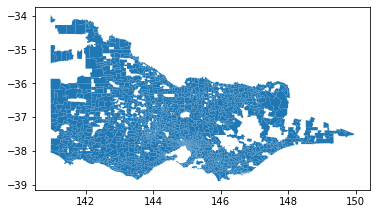

In [31]:
# join the permits data with digital boundaries for suburbs and localities
# the match rate appears to be > 99%, which is more than acceptable
gdf_suburbs = gdf[['SAL_NAME21','Suburb','geometry']].merge(df, on = ['Suburb'], how="right")
gdf_suburbs[['Suburb','geometry']].drop_duplicates().plot()


In [32]:
# Lets enumerate how many did and did not successfully match up with the official suburb data!
print(f"Suburbs not matched with geometry\n")
print(f"Counts:\n{gdf_suburbs['geometry'].isna().value_counts()}\n")
print(f"Percentages:\n{100*(gdf_suburbs['geometry'].isna().value_counts())/len(gdf_suburbs)}")
# About 0.29% not matched

Suburbs not matched with geometry

Counts:
False    334025
True        961
Name: geometry, dtype: int64

Percentages:
False    99.713122
True      0.286878
Name: geometry, dtype: float64


In [69]:
suburb_year_counts[2019]

0         0.0
1       100.0
2        74.0
3         0.0
4         4.0
        ...  
2941      0.0
2942      4.0
2943      0.0
2944      0.0
2945      0.0
Name: 2019, Length: 2946, dtype: float64

<AxesSubplot:>

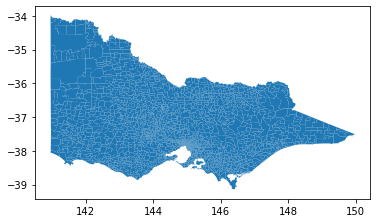

In [83]:
# Create a constant as a non NA utility variable to use for aggregation
gdf_suburbs['constant'] = 1
# Aggregate by Year and Suburb, getting counts of permits by suburb for each year, and dropping any NA values
suburb_year_counts = gdf[['SAL_NAME21','Suburb','geometry']].merge(
        gdf_suburbs.groupby(['Year','Suburb'])['constant'].sum().unstack(0).reset_index(), 
           on = ['Suburb'], how="left")
suburb_year_counts[[2019,2020,2021]] = suburb_year_counts[[2019,2020,2021]].fillna(0)
suburb_year_counts = suburb_year_counts.dropna()
suburb_year_counts.plot()

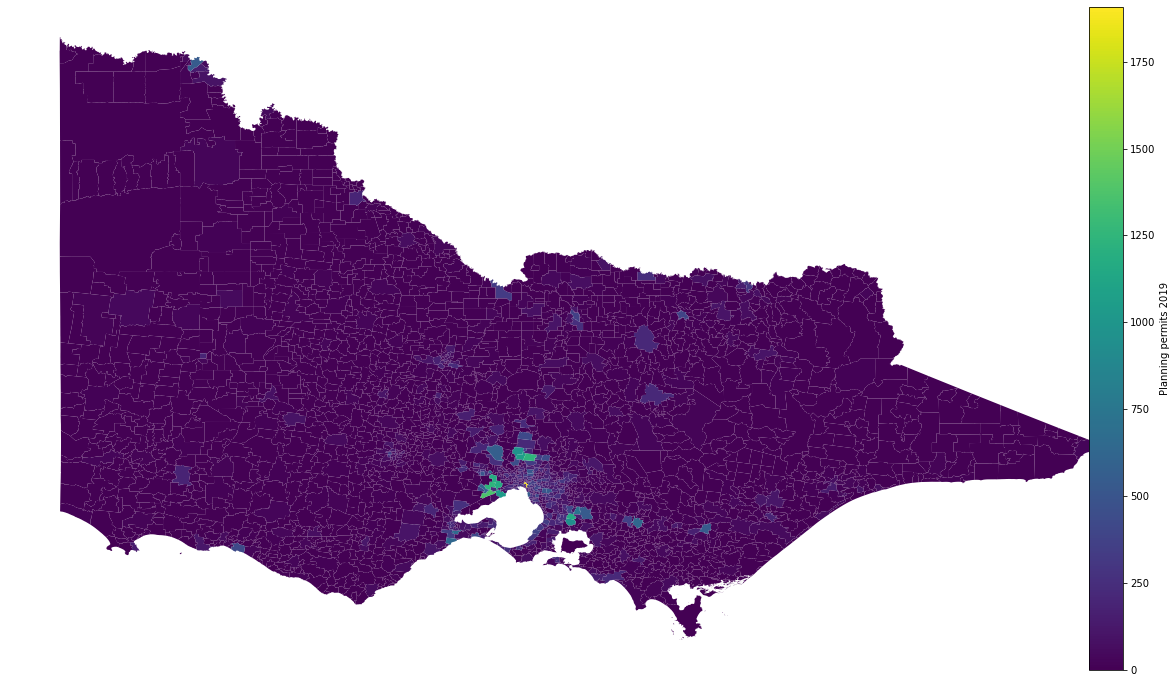

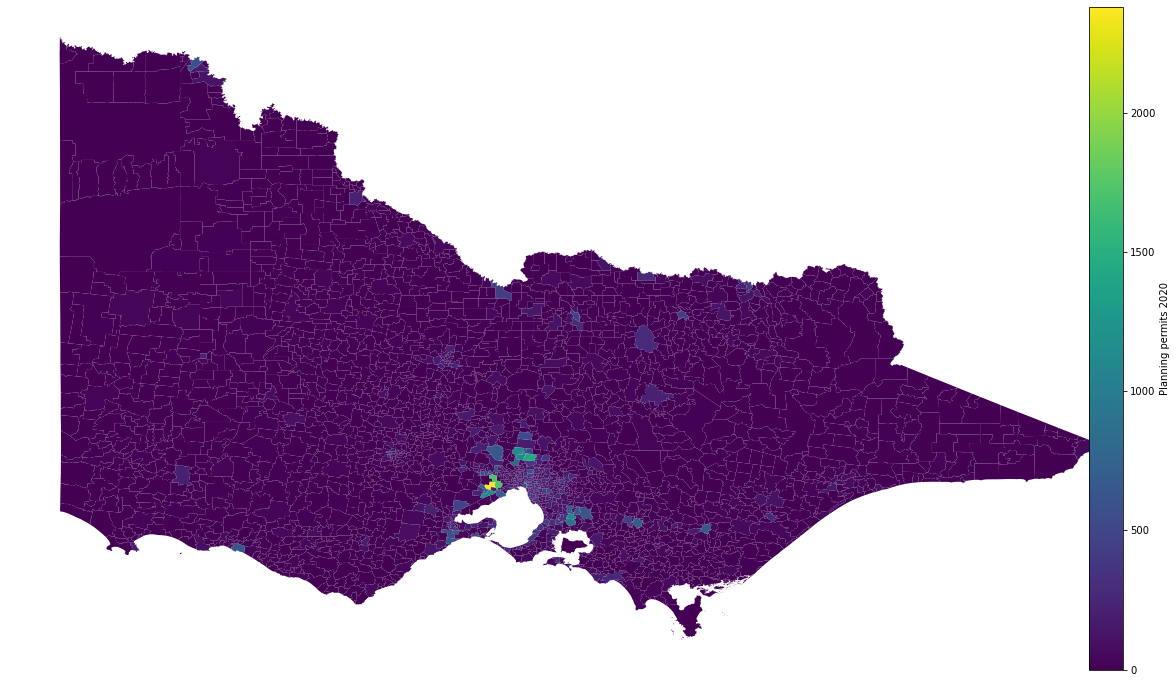

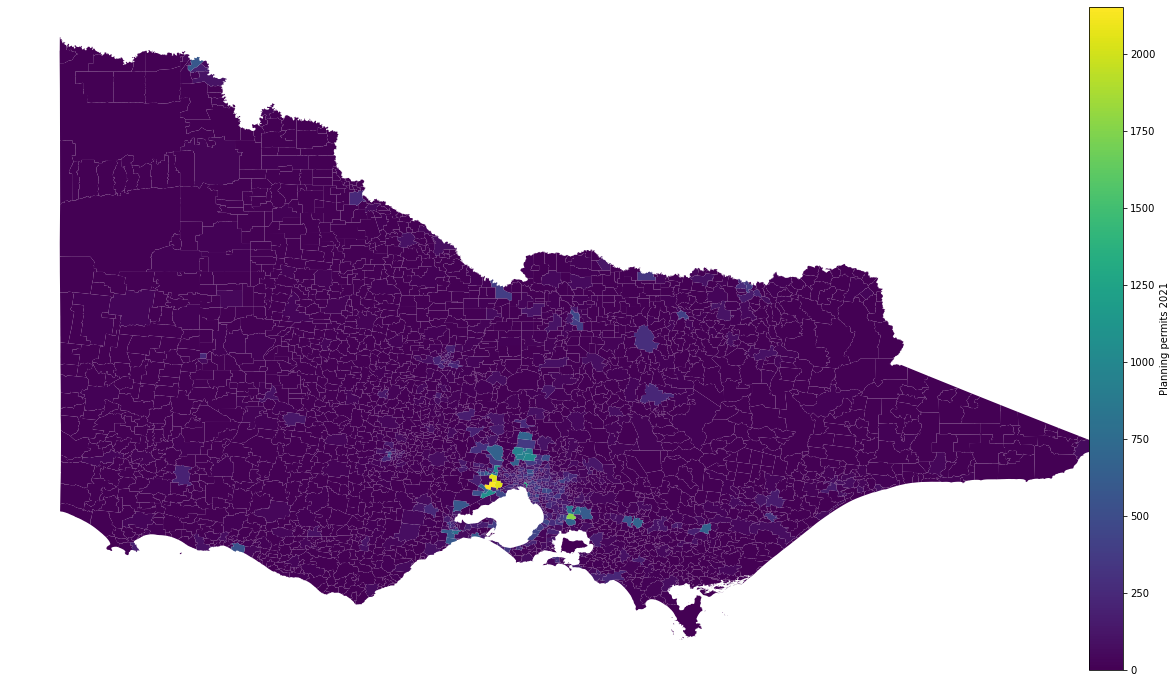

In [84]:
# OPTIONAL: Display using geopandas
for year in [2019,2020,2021]:
    fig, ax = plt.subplots(1,1, figsize=(20,20))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=-1) #resize the colorbar
    suburb_year_counts.plot(
        column=year, 
        ax=ax,
        cax=cax,  
        legend=True,
        legend_kwds={'label': f"Planning permits {year}"})
    #suburb_year_counts.geometry.boundary.plot(color='#BABABA', ax=ax, linewidth=0.3) #Add some borders to the geometries
    ax.axis('off')

In [35]:
# maybe use a bounding box to crop the geodataframe, to focus on Greater Melbroune?
# the hotspot in the West (and to a lesser extent, East) looks interesting!

<AxesSubplot:>

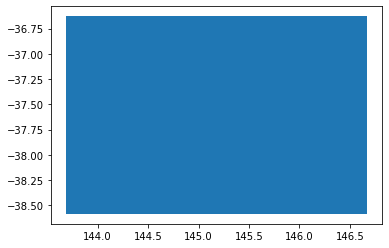

In [36]:
# a bounding box focusing on Metropolitan centres surrounding Melbourne including Ballarat, Bendigo, Geelong, and Traralgon
from shapely.geometry import Polygon
metropolitan_bbox = Polygon([(143.6907440185,-38.5858733556),(146.6680389404,-38.5858733556),(146.6680389404,-36.6277818592),(143.6907440185,-36.6277818592),(143.6907440185,-38.5858733556)])
gdf_metro = gpd.GeoDataFrame([1], geometry=[metropolitan_bbox], crs=4326)
gdf_metro.plot()



In [74]:
suburb_metro


,SAL_NAME21,Suburb,geometry,Year,Permits
1,Abbotsford (Vic.),Abbotsford,"POLYGON ((145.00195 -37.79665, 144.99926 -37.7...",2019,100.0
2,Abbotsford (Vic.),Abbotsford,"POLYGON ((145.00195 -37.79665, 144.99926 -37.7...",2020,106.0
3,Abbotsford (Vic.),Abbotsford,"POLYGON ((145.00195 -37.79665, 144.99926 -37.7...",2021,87.0
4,Aberfeldie,Aberfeldie,"POLYGON ((144.89576 -37.76514, 144.89343 -37.7...",2019,74.0
5,Aberfeldie,Aberfeldie,"POLYGON ((144.89576 -37.76514, 144.89343 -37.7...",2020,70.0
...,...,...,...,...,...
7118,Yuulong,Yuulong,"POLYGON ((143.32185 -38.68969, 143.32550 -38.6...",2021,4.0
7119,Zeerust,Zeerust,"POLYGON ((145.40454 -36.25294, 145.40695 -36.2...",2019,4.0
7120,Zeerust,Zeerust,"POLYGON ((145.40454 -36.25294, 145.40695 -36.2...",2020,3.0
7121,Zeerust,Zeerust,"POLYGON ((145.40454 -36.25294, 145.40695 -36.2...",2021,2.0


# Permit Volume by Year Barchart

In [113]:
df['Number of Permits'] = len(df.index)

df_permit_volume = df.groupby(['Year']).count().reset_index()
fig = px.bar(df_permit_volume, x='Year', y= 'Number of Permits')

fig.update_layout(hoverlabel=dict(bgcolor="white",
                                  font_size=14,
                                  font_family="Arial",
                                  font_color='Black',
                                  bordercolor="rgba(255,255,255,255)"),
                 plot_bgcolor='#f2f2f2')

fig.update_xaxes(type='category',title= None)

fig.update_layout(barmode='stack', bargap=0.20, width =600 , margin=dict(pad=10))

fig.show()
fig.write_html(f'{visuals}Permit_Volume_Bar.html')

# Permit Volume by Year Choropleth Map

In [114]:
import folium
from folium.features import GeoJson, GeoJsonTooltip, GeoJsonPopup
m = folium.Map(location=(gdf_metro.geometry.centroid.y[0],
                         gdf_metro.geometry.centroid.x[0]), 
               zoom_start=8, 
               tiles='CartoDB positron')
suburb_geoms = suburb_year_counts[['Suburb',2019,2020,2021,'geometry']].to_crs({'init': 'epsg:4326'})
suburb_geoms.geometry = suburb_geoms.simplify(tolerance=0.001)
choropleths = {}
for year in [2019,2020,2021]:
    show = False
    if year==2021:
        show = True
    
    choropleths[year] = folium.Choropleth(
        geo_data=suburb_geoms.to_json(),
        data=suburb_year_counts[['Suburb', year]],
        columns=['Suburb', year],
        key_on='properties.Suburb',
        fill_color='Purples',
        fill_opacity=0.7,
        line_opacity=0,
        legend_name=f'Permits',
        bins = [0, 400, 800, 1200, 1600, 2000, 2400],
        name = f'{year} Permit counts',
        #overlay = True,
        show = show
    ).add_to(m)
    if year!=2021:
        for key in choropleths[year]._children:
            if key.startswith('color_map'):
                del(choropleths[year]._children[key])
    choropleths[year].add_to(m)
    #Add layers for Popup and Tooltips
    popup = GeoJsonPopup(
        fields=['Suburb','2019','2020','2021'],
        aliases = ['Suburb','2019 Permits','2020 Permits','2021 Permits'],
        localize=True,
        labels=True,
        style="background-color: yellow;",
    )
    tooltip = GeoJsonTooltip(
        fields=['Suburb','2019','2020','2021'],
        aliases = ['Suburb','2019 Permits','2020 Permits','2021 Permits'],
        localize=True,
        sticky=False,
        labels=True,
        style="""
            background-color: #F0EFEF;
            border: 1px solid black;
            border-radius: 3px;
            box-shadow: 3px;
        """,
        max_width=800,
    )
    folium.GeoJson(
        suburb_geoms.to_json(),
        style_function=lambda feature: {
            'fillColor': '#ffff00',
            'color': 'black',
            'weight': 0,
            'line_opacity':0,
        },
        tooltip=tooltip,
        popup=popup).add_to(choropleths[year])

    
# Layer selection
folium.LayerControl(collapsed=False).add_to(m)
m.save(f'{visuals}Choropleth Permits.html')


# Building Use by Parallel Coordinates Chart

In [ ]:
# Fix up spelling errors

df['BASIS Building Use'].unique()


In [ ]:
df['BASIS Building Use'] = df['BASIS Building Use'].str.title()
df['BASIS Building Use'].unique()

In [ ]:
# Need to turn different building uses into separate variables with percentage values per year to use as dimensions?
# https://plotly.com/python/parallel-coordinates-plot/

df_building_use = df.groupby(['Year','Month'])['BASIS Building Use'].sum().reset_index()
 

fig = px.parallel_coordinates(df_building_use, color="Year",
                              dimensions=['BASIS Building Use'],
                              color_continuous_scale=px.colors.diverging.Tealrose,
                              color_continuous_midpoint=2)
fig.show()









# Nature of Work by Category Line Chart

# Nature of Work by Building Use Heatmap

In [ ]:
colours = ['#c4c8ff','#9ca3ff','#838cfc','#636efa','#3d4bfc']
years = [2019,2020,2021]
construction_by_use = {}
for year in years:
    construction_by_use[year] = pd.pivot_table(df.loc[df['Year']==year], 
                                              values = 'Permit Application Date', 
                                              index = ['BASIS Building Use'],
                                              columns = ['BASIS NOW'],
                                             aggfunc = 'count')
    construction_by_use[year] = construction_by_use[year]\
        .fillna(0).astype(int).style.background_gradient(cmap="Blues")


In [ ]:
construction_by_use[2020] 

In [ ]:
construction_by_use[2021] 

In [ ]:


colours = ['#c4c8ff','#9ca3ff','#838cfc','#636efa','#3d4bfc']
construction_by_use = pd.pivot_table(df, 
                                          values = 'Permit Application Date', 
                                          index = 'BASIS Building Use',
                                          columns = ['BASIS NOW'],
                                         aggfunc = 'count')
construction_by_use = construction_by_use.fillna(0).astype(int)


In [ ]:
# Colour midpoint change not working...


colours = ['#c4c8ff','#9ca3ff','#838cfc','#636efa','#3d4bfc']

fig = px.imshow(construction_by_use,
                labels=dict(x='BASIS NOW', y='BASIS Building Use', color = 'Frequency', showgrid = False, transpose = True),
                width=800, height=600,
                aspect= 'auto',
                color_continuous_scale=['#e8eafc','#c4c8ff','#9ca3ff','#838cfc','#636efa','#3d4bfc'],
                color_continuous_midpoint=(100000),
                range_color= [0,170000]
               )

fig.update_layout(xaxis_showgrid=False, yaxis_showgrid=False, plot_bgcolor= 'white', 
                  hoverlabel=dict(bgcolor="white",
                                  font_size=14,
                                  font_family="Arial",
                                  font_color='Black',
                                  bordercolor="rgba(255,255,255,255)"))
fig.update_annotations('Frequency')

fig.update_yaxes(title= None)
fig.update_xaxes(title= None)

fig.show()
fig.write_html(f'{visuals}Construction_By_Use.html')
#px.offline.plot(data, filename='file.html')


# Estimated Cost by Year Line Chart

In [ ]:
## Still to do - make months words, round number in hoverlabel (code doesn't seem to be working...)

colours = ['#c4c8ff','#838cfc','#3d4bfc']

df_estimated_cost = df.groupby(['Year','Month'])['Total Estimated Cost of Works'].mean().reset_index()


df_estimated_cost.round({"Total Estimated Cost of Works":8})
                             


fig = px.line(df_estimated_cost, 
             x='Month',
             y='Total Estimated Cost of Works', 
             color='Year',
             markers = False, 
              render_mode="SVG",
              hover_data={'Month':False},
             color_discrete_sequence=colours)

fig.update_xaxes(ticklabelposition="inside top", title=None,)
fig.update_yaxes(title= None, showgrid = True, showticklabels = True)

fig.update_layout(hoverlabel=dict(bgcolor="white",
                                  font_size=14,
                                  font_family="Arial",
                                  font_color='Black',
                                  bordercolor="rgba(255,255,255,255)"),
                 plot_bgcolor='#f2f2f2')
                 
fig.update_layout(hovermode="x unified", showlegend = True)

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.05,
    xanchor="right",
    x=1,
))

fig.update_layout(legend={'title_text':''})

fig.update_traces(line=dict(width=4),hovertemplate=None)


fig.show()

fig.write_html(f'{visuals}Cost_By_Year.html')


# Reported Cost by Year Choropleth Map

# Ecofeatures Horizontal Barchart

In [ ]:
eco_features = df.reset_index()
for year in test.Year.unique():
    print(f'\n{year}')
    print(eco_features.loc[eco_features['Year']==year,'Solar Hot Water'].value_counts())
    print(eco_features.loc[eco_features['Year']==year,'Solar Hot Water'].count())
    print("PERCENTAGES")
    print(eco_features.loc[eco_features['Year']==year,'Solar Hot Water'].value_counts()/eco_features.loc[eco_features['Year']==year,'Solar Hot Water'].count())

In [ ]:
percentages = {}
for p in ['Solar Hot Water','Rainwater Tank']:
    percentages[p] = (100*(eco_features.loc[test[p]=='Yes'].groupby('Year')[p].count()/eco_features.groupby('Year')[p].count())).round(1)
    
percentages

In [ ]:
eco_features = pd.DataFrame(percentages)
#.to_markdown()
print(eco_features.to_markdown())

In [ ]:
color = '#9ca3ff'

fig = px.bar(eco_features)

fig.update_layout(hoverlabel=dict(bgcolor="white",
                                  font_size=14,
                                  font_family="Arial",
                                  font_color='Black',
                                  bordercolor="rgba(255,255,255,255)"),
                 plot_bgcolor='#f2f2f2')

#fig.update_traces(hovertemplate='<b>Uptake: %{y}</b> Year: <b>%{x}')

fig.update_xaxes(type='category',title= None)
fig.update_yaxes(title = None, ticksuffix="%", tick0=5, dtick=5)

fig.update_layout(barmode='group', bargap=0.20, width =700 , margin=dict(pad=10))

fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="right",
    x=1,
))

fig.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig.update_layout(legend={'title_text':''})

fig.show()

fig.write_html(f'{visuals}Eco_Features_Bar.html')

